## モジュールimport

In [2]:
%load_ext memory_profiler
%memit

peak memory: 216.07 MiB, increment: 2.58 MiB


In [3]:

import pandas as pd
import numpy as np
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import optuna.integration.lightgbm as lgb
from sklearn.metrics import accuracy_score
import pickle
import gc

## データ読み込み

In [4]:
df = pd.read_csv('/volume_dir/boatrace/merged_df1.csv')
#odds = pd.read_csv('/volume_dir/boatrace/odds_csv/odds.csv')


In [5]:
%memit

peak memory: 1603.33 MiB, increment: 0.01 MiB


## 関数

In [6]:
# 4位以下の着順を4で統一
def order_4(df):
    clip_order = lambda x: 0 if x==0 else (x if x<4 else 0)
    df['order'] = df['order'].map(clip_order)
    return df
# 三着以内かそれ以外かで統一
def order_1(df):
    clip_order = lambda x: 0 if x==0 else (1 if x<4 else 0)
    df['order'] = df['order'].map(clip_order)
    return df
# 時系列で整列して、不均衡な目的変数を均衡にする
# train 0.7 val 0.15 test 0.15
def train_test_split_data(df,test_size):
    sorted_id_list = df.sort_values('race_date').index.unique()
    train_id_list = sorted_id_list[:round(len(sorted_id_list)*(1-test_size))]
    middle_list = round((len(sorted_id_list)-(len(sorted_id_list)*(1-test_size)))/2)
    vaild_id_list = sorted_id_list[round(len(sorted_id_list)*(1-test_size)):round((len(sorted_id_list)*(1-test_size)))+middle_list]
    test_id_list = sorted_id_list[round((len(sorted_id_list)*(1-test_size)))+middle_list:]
    train = df.loc[train_id_list]
    test = df.loc[test_id_list]
    vaild = df.loc[vaild_id_list]
    X_train = train.drop(['order','race_date'], axis=1)
    y_train = train['order']
    X_val = vaild.drop(['order','race_date'], axis=1)
    y_val = vaild['order']
    X_test = test.drop(['order','race_date'], axis=1)
    y_test = test['order']
    X_train_rus, y_train_rus = rus(X_train,y_train)
    X_val_rus, y_val_rus = rus(X_val,y_val)
    print('X_train.shape:{}'.format(X_train.shape))
    print('y_train.shape:{}'.format(y_train.shape))
    print('X_train_rus.shape:{}'.format(X_train_rus.shape))
    print('y_train_rus.shape:{}'.format(y_train_rus.shape))
    print('X_val_rus.shape:{}'.format(X_val_rus.shape))
    print('y_val_rus.shape:{}'.format(y_val_rus.shape))
    print('X_test.shape:{}'.format(X_test.shape))
    print('y_test.shape:{}'.format(y_test.shape))
    return X_train_rus, y_train_rus,X_val_rus,y_val_rus,X_test, y_test

def rus(X_train,y_train):
    order_1 = y_train.value_counts()[1]
    order_2 = y_train.value_counts()[2]
    order_3 = y_train.value_counts()[3]
    strategy = {1:order_1,2:order_2,3:order_3,0:order_1}
    rus = RandomUnderSampler(sampling_strategy = strategy,random_state=42)
    
    X_train_rus, y_train_rus = rus.fit_resample(X_train,y_train)
    
    return X_train_rus, y_train_rus

def rus_b(X_train,y_train):
    order_1 = y_train.value_counts()[0]
    strategy = {0:order_1,1:order_1}
    rus = RandomUnderSampler(sampling_strategy = strategy,random_state=42)
    
    X_train_rus, y_train_rus = rus.fit_resample(X_train,y_train)
    
    return X_train_rus, y_train_rus

def train_test_split_data_b(df,test_size):
    sorted_id_list = df.sort_values('race_date').index.unique()
    train_id_list = sorted_id_list[:round(len(sorted_id_list)*(1-test_size))]
    middle_list = round((len(sorted_id_list)-(len(sorted_id_list)*(1-test_size)))/2)
    vaild_id_list = sorted_id_list[round(len(sorted_id_list)*(1-test_size)):round((len(sorted_id_list)*(1-test_size)))+middle_list]
    test_id_list = sorted_id_list[round((len(sorted_id_list)*(1-test_size)))+middle_list:]
    train = df.loc[train_id_list]
    test = df.loc[test_id_list]
    vaild = df.loc[vaild_id_list]
    X_train = train.drop(['order','race_date'], axis=1)
    y_train = train['order']
    X_val = vaild.drop(['order','race_date'], axis=1)
    y_val = vaild['order']
    X_test = test.drop(['order','race_date'], axis=1)
    y_test = test['order']
    X_train_rus, y_train_rus = rus_b(X_train,y_train)
    X_val_rus, y_val_rus = rus_b(X_val,y_val)
    print('X_train.shape:{}'.format(X_train.shape))
    print('y_train.shape:{}'.format(y_train.shape))
    print('X_train_rus.shape:{}'.format(X_train_rus.shape))
    print('y_train_rus.shape:{}'.format(y_train_rus.shape))
    print('X_val_rus.shape:{}'.format(X_val_rus.shape))
    print('y_val_rus.shape:{}'.format(y_val_rus.shape))
    print('X_test.shape:{}'.format(X_test.shape))
    print('y_test.shape:{}'.format(y_test.shape))
    return X_train_rus, y_train_rus,X_val_rus,y_val_rus,X_test, y_test
# oddsの表記をint型に変換
def odds_astype(odds):
    odds = odds = odds.dropna(how='any')
    for index in ['p_3_m','p_3_d_m','p_2_m','p_2_d_m']:
        odds[index] = odds[index].astype('int')
    return odds



## 実行

In [7]:
drop_columns = ['race_code','number','in','title', 'race_name','race_time']

In [8]:
df.drop(drop_columns,axis=1,inplace=True)

In [9]:
df['race_date'] = pd.to_datetime(df['race_date'])

In [10]:
categorical_features = ['place','name','type', 'weather', 'wind', 'area', 'class']

In [11]:
for list in categorical_features:
    df[list] = df[list].astype('category')

In [12]:
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

In [13]:
%memit

peak memory: 5440.40 MiB, increment: 0.00 MiB


In [14]:
df = order_1(df)

In [15]:
df_x = df.drop(['order','race_date'],axis=1)
df_y = df['order']

In [16]:
X_train,X_test,y_train,y_test = train_test_split(df_x,df_y,test_size=0.2,random_state=0)

In [13]:
X_train_rus, y_train_rus,X_val_rus,y_val_rus,X_test, y_test  = train_test_split_data_b(df,0.3)

: 

: 

In [17]:
%memit

peak memory: 14975.13 MiB, increment: 0.00 MiB


In [18]:
del df
gc.collect()

21

## モデル

In [24]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_train_rus, y_train_rus)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass', # 目的 : 多クラス分類 
        'num_class': 4, # クラス数 : 3
        'metric': {'multi_logloss'}, # 評価指標 : 誤り率(= 1-正答率) 
        # 他には'multi_logloss'など
}

# モデルの学習
model = lgb.train(params,
train_set=lgb_train, # トレーニングデータの指定
valid_sets=lgb_eval, # 検証データの指定
)

# テストデータの予測 ((各クラスの予測確率 [クラス0の予測確率,クラス1の予測確率,クラス2の予測確率] を返す))
y_pred_prob = model.predict(X_test)
# テストデータの予測 (予測クラス(0 or 1 or 2)を返す)
y_pred = np.argmax(y_pred_prob, axis=1) # 一番大きい予測確率のクラスを予測クラスに

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6722
[LightGBM] [Info] Number of data points in the train set: 1078543, number of used features: 1881
[LightGBM] [Info] Start training from score -1.374591
[LightGBM] [Info] Start training from score -1.374591
[LightGBM] [Info] Start training from score -1.395182
[LightGBM] [Info] Start training from score -1.401100
[1]	valid_0's multi_logloss: 1.32042
[2]	valid_0's multi_logloss: 1.27255
[3]	valid_0's multi_logloss: 1.23405
[4]	valid_0's multi_logloss: 1.20248
[5]	valid_0's multi_logloss: 1.176
[6]	valid_0's multi_logloss: 1.15388
[7]	valid_0's multi_logloss: 1.13526
[8]	valid_0's multi_logloss: 1.11981
[9]	valid_0's multi_logloss: 1.10622
[10]	valid_0's multi_logloss: 1.09439
[11]	valid_0's multi_logloss: 1.08439
[12]	valid_0's multi_logloss: 1.07555
[13]	valid_0's multi_logloss: 1.06808
[14]	

In [28]:
with open('model_1.pkl','wb') as model_file:
    pickle.dump(model,model_file)

In [18]:
# 真値と予測値の表示
df_pred = pd.DataFrame({'target':y_test,'target_pred':y_pred})
display(df_pred)

# 真値と予測確率の表示
df_pred_prob = pd.DataFrame({'y':y_test, 'target0_prob':y_pred_prob[:,0], 'target1_prob':y_pred_prob[:,1], 'target2_prob':y_pred_prob[:,2]})
display(df_pred_prob)

,target,target_pred
1318162,0,2
1318163,0,2
1318164,0,0
1318165,1,2
1318166,2,3
...,...,...
1442866,3,0
1442865,2,3
1442864,1,1
1442871,2,3


,y,target0_prob,target1_prob,target2_prob
1318162,0,0.299771,0.022240,0.340571
1318163,0,0.285447,0.117424,0.301647
1318164,0,0.302748,0.213025,0.223564
1318165,1,0.136516,0.300276,0.337028
1318166,2,0.249034,0.227113,0.223167
...,...,...,...,...
1442866,3,0.477430,0.008280,0.193423
1442865,2,0.193206,0.011075,0.391824
1442864,1,0.000876,0.995376,0.002514
1442871,2,0.354074,0.009997,0.251191


In [1]:
acc = accuracy_score(y_test,y_pred)
print('Acc :', acc)

NameError: name 'accuracy_score' is not defined

In [19]:
trainval = lgb.Dataset(X_train,y_train)
params = {
    'objective' : 'binary',
    'metric': 'binary_logloss',
    'ramdom_seed' : 42
}

In [20]:
tuner = lgb.LightGBMTunerCV(params,trainval,verbose_eval=100,early_stopping_rounds=100,folds=KFold(n_splits=3))
tuner.run()

[I 2023-03-13 01:44:20,391] A new study created in memory with name: no-name-abd8ae3f-ecc3-4792-a191-141b094ab610
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


: 

: 

In [ ]:
best_params = tuner.besst

In [19]:
import optuna.integration.lightgbm as lgb_o
# 学習に使用するデータを設定
train_data = lgb_o.Dataset(X_train, label=y_train)
valid_data= lgb_o.Dataset(X_test, y_test, reference=train_data)

params = {'task': 'train',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'objective': 'binary',
    'num_class': 4,
    'learning_rate': 0.05,
    'seed': 42,
    'verbosity': -1,
    'num_iterations': 10000,
    'early_stopping_round': 100}

In [20]:
best_params={}
gbm = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=10000,
    early_stopping_rounds=100,
    verbose_eval=20,
)

best_params= gbm.params
best_params

[I 2023-03-13 01:46:44,140] A new study created in memory with name: no-name-80332fba-1dac-4793-80d1-434587b887ae
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


: 

: 

In [22]:
#予測
preds = gbm.predict(X_test, num_iteration=gbm.best_iteration)

y_pred = []
for x in preds:
    y_pred.append(np.argmax(x))
#評価指標は以下４つ
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
#正解率など評価指標の計算
print('正解率(accuracy_score):{}'.format(accuracy_score(y_test, y_pred)))
#適合率、再現率、F1値はマクロ平均を取る
print('再現率(recall_score):{}'.format(recall_score(y_test, y_pred, average='macro')))
print('適合率(precision_score):{}'.format(precision_score(y_test, y_pred, average='macro')))
print('F1値(f1_score):{}'.format(f1_score(y_test, y_pred, average='macro')))


正解率(accuracy_score):0.543132466309657
再現率(recall_score):0.5331193170409179
適合率(precision_score):0.4922485149284439
F1値(f1_score):0.5031637269222022


In [23]:
with open('model_gbm_2.pkl','wb') as model_file:
    pickle.dump(gbm,model_file)

In [21]:
importance = pd.DataFrame(gbm.feature_importance(), index=X_train_rus.columns, columns=['importance'])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

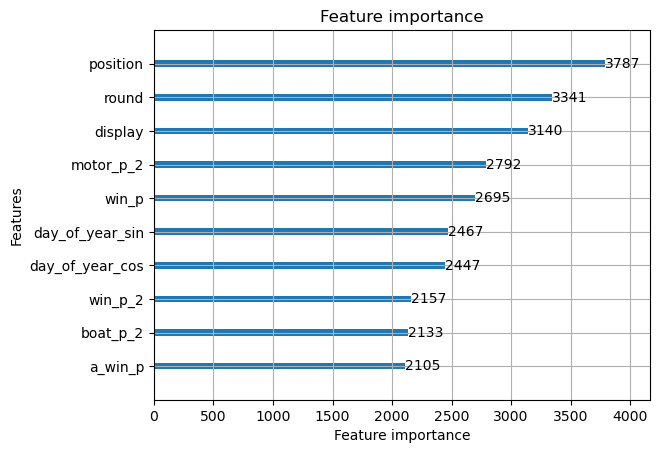

In [22]:
lgb.plot_importance(gbm,max_num_features=10)

## 検証

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
import seaborn as sns; sns.set()
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
import re
from bs4 import BeautifulSoup
from urllib import request
from urllib.request import urlopen
import time
import pickle
from sklearn.preprocessing import StandardScaler

In [23]:
predict_day = input('予測したい日をyyyymmdd型で入力:')
jcd = input('予測したい場を2桁で入力:')
rno = input('予測したいラウンドを入力:')

In [98]:
url = 'https://www.boatrace.jp/owpc/pc/race/beforeinfo?rno='+str(rno)+\
        '&jcd='+str(jcd).zfill(2)+'&hd='+str(predict_day)
time.sleep(1)
response = request.urlopen(url)
soup = BeautifulSoup(response,'html.parser')
response.close()
data_2 = []
for i in range(0,6):
    table = soup.find_all('tbody',class_='is-fs12')[i].get_text()
    table = table.replace('\n\n','').replace('\u3000','').replace('\n',',')
    table_data = table.split(',')
    position_name = table_data[0]
    name = position_name[1:]
    display = table_data[2]
    table2 = soup.find_all('tbody',class_='is-p10-0')[0].get_text()
    table2 = table2.replace('\n\n\n','').replace('\n\n',',').replace('\n',',')
    table2_data = table2.split(',')
    st_times = {'st_time_1':table2_data[2],'st_time_2':table2_data[4],'st_time_3':table2_data[6],\
        'st_time_4':table2_data[8],'st_time_5':table2_data[10],'st_time_6':table2_data[12]}
    table3 = soup.find('div',class_='weather1_body').get_text()
    table3 = table3.replace('\n\n\n\n','').replace('\n',',')
    table3_data = table3.split(',')
    weather = table3_data[3]
    wind_strong = table3_data[5].replace('m水温','')
    wave = table3_data[8].replace('cm','')
    data_2.append([name,display,st_times['st_time_{}'.format(i+1)],weather,wind_strong,wave])
df_2 = pd.DataFrame(data_2,columns=['name','display','st_time','weather','wind_strong','wave'])

In [121]:
url = 'https://www.boatrace.jp/owpc/pc/race/beforeinfo?rno='+str(rno)+\
        '&jcd='+str(jcd).zfill(2)+'&hd='+str(predict_day)
time.sleep(1)
response = request.urlopen(url)
soup = BeautifulSoup(response,'html.parser')
response.close()

In [136]:
table2 = soup.find_all('tbody',class_='is-fs12')[2].get_text()

In [137]:
table2

'\n\n3\n\n尾形\u3000\u3000栄治\n52.4kg\n6.99\n0.5\n\xa0\n\n\n\n\nR\n\xa0\n\n\n進入\n\xa0\n\n\n0.0\nST\n\xa0\n\n\n着順\n\n\n'

In [138]:
table2 = table2.replace('\u3000','').replace('\n\n','').replace('\n',',').split(',')

In [139]:
table2[2]

'6.99'

In [100]:
st_times = {'st_time_1':table2_data[2],'st_time_2':table2_data[4],'st_time_3':table2_data[6],\
        'st_time_4':table2_data[8],'st_time_5':table2_data[10],'st_time_6':table2_data[12]}

In [99]:
df_2.head()

,name,display,st_time,weather,wind_strong,wave
0,萬正嗣,6.83,.04,晴,8,10
1,宇留田翔平,6.84,.06,晴,8,10
2,尾形栄治,6.99,F.02,晴,8,10
3,金山立樹,6.84,.01,晴,8,10
4,大塚雅治,6.69,.09,晴,8,10
